In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import io
import requests
import statsmodels.api as sm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import warnings
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics

url1 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/other_train.csv"
url2 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/personal_train.csv"
url3 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/other_valid.csv"
url4 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/personal_valid.csv"

db1 = requests.get(url1).content
db2 = requests.get(url2).content
db3 = requests.get(url3).content
db4 = requests.get(url4).content
personal_train = pd.read_csv(io.StringIO(db1.decode('utf-8')))
other_train = pd.read_csv(io.StringIO(db2.decode('utf-8')))
personal_valid = pd.read_csv(io.StringIO(db3.decode('utf-8')))
other_valid = pd.read_csv(io.StringIO(db4.decode('utf-8')))

### Predspracovanie nového datasetu nami realizovaným postupom predspracovania a opis prípadných zmien

Predspracovanie nového datasetu prebehol za pomoci funkcií, ktoré sme využili pri úprave dát v minulom odovzdaní. Tieto funkcie sú následne volané v hlavnej funkcií repair_data(), v ktorá má na starosti celé predspracovanie dát.

Táto funkcia bola vytvorená refaktorovaním predošlého odovzdania tak, aby naraz urobila cellú akciu predspracovania datasetu. Zmeny v kóde oproti minulému odovzdaniu nenastali. Jednotlivé kroky funkcie sú opísané komentármi.

In [38]:
def sanitize_boolean(boolean):
    try:
        if boolean.strip() in ['f','F','FALSE','false','False']:
            return 0
        elif boolean.strip() in ['t','T','TRUE','true','True']:
            return 1
        else:
            return np.nan
    except AttributeError:
        return np.nan
    
def sanitize_pregnancy(data):
    data.loc[(data.sex == 1),'pregnant'] = 0
    return data
    
def sanitize_sex(sex):
    return 1 if sex.strip() == 'Male' else 0

def sanitize_age(data):
    data.loc[(data.age == '-1'),'age'] = np.nan
    data.loc[(data.age == '??'),'age'] = np.nan
    return data

def sanitize_number(number):
    try:
        sanitized = int(pd.to_numeric(number, errors="coerce"))
        return sanitized if sanitized > 0 else np.nan
    except AttributeError:
        return np.nan
    except ValueError:
        return np.nan
    
def sanitize_date(date):
    date = str(date).replace('/', '-')
    date = date[:10]
    date = date.split("-")
    
    if date[0] != 'nan':
        if len(date[0]) != 4:
            if len(date[2]) == 2 and int(date[0]) > 31:
                new_date = "19"+ date[0] +"-"+date[1]+"-"+date[2] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) > 31)):
                new_date = "19"+date[2]+"-"+date[1]+"-"+date[0] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) < 31)):
                new_date = "20"+ date[2] + "-" +date[1]+"-" + date[0] 
            else:
                new_date = date[2]+"-"+date[1]+"-"+date[0] 
            return new_date        
    return '-'.join(date)
        
def fill_null_age(age,date):
    if (date):
        return (measure_year - int(date.split('-')[0]))[0]
    return np.nan

def sanitize_string(string):
    try:
        string = string.strip()
        if string in ['None', 'nan', '??', '?']:
            return np.nan
        return string
    except AttributeError:
        return np.nan
    
def sanitize_relationship(relation):
    if relation in ('Married', 'Husband', 'Wife'):
        return 'Married'
    if relation in ('Not-Married', 'Not-in-family', 'Unmarried', 'Own-child', 'Other-relative'):
        return 'Not-Married'
    if relation == 'Divorced/Widowed':
        return relation
    return np.nan

def sanitize_marital_status(married):
    if married in ('Married', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'):
        return 'Married'
    if married in ('Not-Married', 'Never-married'):
        return 'Not-Married'
    if married in ('Separated', 'Divorced', 'Widowed'):
        return 'Divorced/Widowed'
    return married

def sanitize_work(string):
    try:
        return string.replace('-','_').capitalize()
    except AttributeError:
        return np.nan
    
def get_education_num(education, data):
    temp = 10.0
    for i in data['education-num'].loc[data.education == education]:
        if (i > 0) & (i < temp):
            temp = i
    return temp

def clear_nan(data, column):
    if data[column].isnull().sum() > 0:
            data.dropna(subset=[column], inplace=True)
    return data

from sklearn.impute import KNNImputer
def replace_null_values_with_KNN_imputer(dataframe, no_of_neighbours):
    numpy_column = dataframe[['kurtosis_glucose', 'mean_oxygen', 'age']].to_numpy()
    numpy_column = np.reshape(numpy_column, (-1,3))

    class_column = dataframe['class'].to_numpy()
    class_column = np.reshape(numpy_column, (-1,1))

    
    imputer = KNNImputer(n_neighbors=no_of_neighbours, weights="uniform")
    numpy_column = imputer.fit_transform(numpy_column, class_column)
    return numpy_column

def replace_null_values_with_KNN_imputer2(dataframe, column, no_of_neighbours):
    numpy_column = dataframe[column].to_numpy()
    numpy_column = np.reshape(numpy_column, (-1,1))
    class_column = dataframe['income'].to_numpy()
    class_column = np.reshape(numpy_column, (-1,1))    
    imputer = KNNImputer(n_neighbors=no_of_neighbours, weights="uniform")
    numpy_column = imputer.fit_transform(numpy_column, class_column)
    return numpy_column

def replace_with_quantiles(df, column):
    new_df = df.copy(deep = True)
    skew_val = sc.skew(new_df[column]) 
    
    if ((skew_val < -2) or (skew_val > 2)):  
        minimum = new_df[column].min()
        minimum = minimum + (-minimum - minimum)
        new_df[column] = np.log(new_df[column]+minimum)
    
    perc_95 = new_df[column].quantile(.95)   
    perc_05 =  new_df[column].quantile(.05)
    new_df.loc[new_df[column] < perc_05, column] = perc_05
    new_df.loc[new_df[column] > perc_95, column] = perc_95
    return new_df

In [39]:
def repair_data(data):
    data.pregnant = data.pregnant.map(sanitize_boolean) # uprava pregnant na ciselnu hodnotu
    data = sanitize_pregnancy(data) # nahradenie mužov na 0
    data.sex = data.sex.map(lambda sex: sanitize_sex(sex)) # prekonvertovanie na numerike hodnoty
    data = sanitize_age(data) # nastavenie neznamych hodnot na np.nan
    data.age = data.age.map(lambda age: sanitize_number(age)) # prekonvertovanie na numericku hodnotu

    # rozdenenie medical info stlpca
    x = data['medical_info'].str.replace('{','').str.replace('\'','').str.replace('}', '').str.split(',', expand=True)
    i = 0
    while i < len(x.columns):
        y = x[i].str.split(':', expand=True)
        data[y[0][0]] = y[1].astype(float)
        i += 1
    data.drop('medical_info', axis='columns', inplace=True)

    data.date_of_birth = data.date_of_birth.map(sanitize_date) # uprava stlpca datum narodenia

    # dopocitanie hodnot stlpca vek
    years = [];
    def find_measure_year(age, date_of_birth):
        if (pd.notnull(age)):
            years.append(int(date_of_birth.split('-')[0]) + int(age))
    data.apply(lambda x: find_measure_year(x.age,x.date_of_birth), axis = 1)
    measure_year = pd.Series(years).mode();

    # odstranenie chybnych hodnot
    median = data[(data.age > 0)].groupby('sex', as_index=False).age.mean()
    data.loc[(data.age < 0), 'age'] = data[data.age < 0].age.map(lambda a: round(median.loc[0, 'age'], 0))

    # prekonvertovanie income na ciselny tvar
    data.income = data.income.map(lambda income: 0 if str(income).strip() == '<=50K' else 1 if str(income).strip() == '>50K' else np.nan)

    # dropnutie nepotrebnych stlpcov v datasete
    data.drop('Unnamed: 0_x', axis='columns', inplace=True)
    data.drop('Unnamed: 0_y', axis='columns', inplace=True)
    data.drop('fnlwgt', axis='columns', inplace=True)

    # uprava stringovych hodnot
    data['race'] = data['race'].map(sanitize_string)
    data.race = data.race.map(lambda race: 'Other' if race in ('Asian-Pac-Islander', 'Amer-Indian-Eskimo') else race)
    data['marital-status'] = data['marital-status'].map(sanitize_string)
    data['relationship'] = data['relationship'].map(sanitize_string)
    data['relationship'] = data['marital-status'].map(sanitize_marital_status)
    data['relationship'] = data['relationship'].map(sanitize_relationship)
    data.drop('marital-status', axis='columns', inplace=True)
    data['occupation'] = data['occupation'].map(sanitize_string)
    data['workclass'] = data['workclass'].map(sanitize_string)
    data['occupation'] = data['occupation'].map(sanitize_work)
    data['workclass'] = data['workclass'].map(sanitize_work)
    data['native-country'] = data['native-country'].map(sanitize_string)

    data = data.drop_duplicates(['name','address','date_of_birth'], keep="last") # odstranenie duplikatov

    # doplnenie education-num
    map = {}
    for i in data.education.unique():
        map[i] = (get_education_num(i, data))
    data.loc[:,'education-num'] = data.education.map(map)

    # doplnenie mean_oxygen a kurtosis_glucose
    data = clear_nan(data, 'class')
    df = data[['kurtosis_glucose', 'mean_oxygen', 'age', 'class']]
    numpy_array = replace_null_values_with_KNN_imputer(df, 5)
    data['kurtosis_glucose'] = numpy_array[:,[0]]
    data['mean_oxygen'] = numpy_array[:,[1]]
    data['age'] = numpy_array[:,[2]]
    
    # doplnenie hours_per_week
    data['hours-per-week'].fillna(round(data['hours-per-week'].mean(), 0), inplace=True)    

    # doplnenie income
    regression = LinearRegression()
    df = data[['hours-per-week','income']]
    df2 = data[['hours-per-week','income']]
    df.dropna(axis=0, how='any', inplace=True)
    X = df['hours-per-week'].values.reshape(-1,1)
    regression.fit(X, df['income'])
    data_null = data['hours-per-week'].loc[(data['income'].isna()) & (~data['hours-per-week'].isna())]
    temp = regression.predict(np.array(data_null).reshape(-1,1))
    temp = [np.round(x, 0) for x in temp]
    data['income'].loc[(data['income'].isna()) & (~data['hours-per-week'].isna())] = temp

    # doplnenie mean_glucose a kurtosis_oxygen
    regression = LinearRegression()
    df = data[['kurtosis_glucose','mean_glucose']]
    df2 = data[['kurtosis_glucose','mean_glucose']]
    df.dropna(axis=0, how='any', inplace=True)
    X = df['kurtosis_glucose'].values.reshape(-1,1)
    regression.fit(X, df['mean_glucose'])
    data_null = data['kurtosis_glucose'].loc[(data['mean_glucose'].isna()) & (~data['kurtosis_glucose'].isna())]
    temp = regression.predict(np.array(data_null).reshape(-1,1))
    data['mean_glucose'].loc[(data['mean_glucose'].isna()) & (~data['kurtosis_glucose'].isna())] = temp
    regression = LinearRegression()
    df = data[['mean_oxygen','kurtosis_oxygen']]
    df2 = data[['mean_oxygen','kurtosis_oxygen']]
    df.dropna(axis=0, how='any', inplace=True)
    X = df['mean_oxygen'].values.reshape(-1,1)
    regression.fit(X, df['kurtosis_oxygen'])
    data_null = data['mean_oxygen'].loc[(data['kurtosis_oxygen'].isna()) & (~data['mean_oxygen'].isna())]
    temp = regression.predict(np.array(data_null).reshape(-1,1))
    data['kurtosis_oxygen'].loc[(data['kurtosis_oxygen'].isna()) & (~data['mean_oxygen'].isna())] = temp

    # doplnenie skewness_glucose, std_glucose, skewness_oxygen, std_oxygen
    regression = LinearRegression()
    df = data[['kurtosis_glucose','skewness_glucose']]
    df2 = data[['kurtosis_glucose','skewness_glucose']]
    df.dropna(axis=0, how='any', inplace=True)
    X = df['kurtosis_glucose'].values.reshape(-1,1)
    regression.fit(X, df['skewness_glucose'])
    data_null = data['kurtosis_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())]
    temp = regression.predict(np.array(data_null).reshape(-1,1))
    data['skewness_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())] = temp
    data = clear_nan(data, 'std_glucose')

    # doplnenie capital_gain a capital_loss
    df = data[['capital-loss', 'income']]
    numpy_array = replace_null_values_with_KNN_imputer2(df, 'capital-loss', 5)
    data['capital-loss'] = numpy_array[:,[0]]
    data['capital-loss'] = np.round(data['capital-loss'], 0)
    df = data[['capital-gain', 'income']]
    numpy_array = replace_null_values_with_KNN_imputer2(df, 'capital-gain', 5)
    data['capital-gain'] = numpy_array[:,[0]]
    data['capital-gain'] = np.round(data['capital-gain'], 0)

    # doplnenie zostavajucich atributov
    data.race = data.race.fillna(data.race.mode()[0])
    data.pregnant = data.pregnant.fillna(data.pregnant.mode()[0])
    data.relationship = data.relationship.fillna(data.relationship.mode()[0])
    data.education = data.education.fillna(data.education.mode()[0])
    data['occupation'] = data['occupation'].fillna(data.occupation.mode()[0])
    data['native-country'] = data['native-country'].fillna(data['native-country'].mode()[0])
    data['workclass'] = data['workclass'].fillna(data.workclass.mode()[0])

    # odstranenie outliers
    data = replace_with_quantiles(data, 'mean_glucose')
    data = replace_with_quantiles(data, 'kurtosis_glucose')
    data = replace_with_quantiles(data, 'mean_oxygen')
    data = replace_with_quantiles(data, 'kurtosis_oxygen')
    data = replace_with_quantiles(data, 'skewness_oxygen')
    data = replace_with_quantiles(data, 'std_oxygen')
    data = replace_with_quantiles(data, 'skewness_glucose')
    data = replace_with_quantiles(data, 'std_glucose')
    
    return data

Sem spojíme datasety validačných a trénovacích atribútov a spustíme nad nimi funkciu predpracovania. Predspracovanie nad obidvoma datasetmi by malo dopadnúť úspešne.

In [40]:
warnings.filterwarnings('ignore')
train = pd.merge(personal_train,other_train,on=['name','address'], how = 'outer')
valid = pd.merge(personal_valid,other_valid,on=['name','address'], how = 'outer')
data_train = repair_data(train)
data_valid = repair_data(valid)

In [41]:
data_train.head(5)

,name,address,race,occupation,pregnant,education-num,relationship,capital-gain,education,class,...,sex,date_of_birth,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Jason Michaels,"498 Kristin Courts Apt. 179\nWest Teresaport, ...",White,Prof_specialty,1.0,10.0,Married,0.0,Masters,0.0,...,1,1966-05-16,111.812500,44.881746,0.725315,0.690782,0.812044,17.289817,8.636118,4.472571
1,Thomas Flynn,"92949 Wall Drives Apt. 679\nNew Tinaburgh, MT ...",White,Sales,0.0,10.0,Married,0.0,Some-college,1.0,...,1,1964-06-29,71.398438,47.295173,1.084843,1.409948,2.827393,46.862830,3.070346,2.432048
2,John Cato,"99749 Michael Unions\nScottstad, IN 48755",White,Prof_specialty,0.0,10.0,Married,0.0,Masters,1.0,...,1,1954-01-25,102.796875,37.534642,0.704884,1.134939,0.913612,19.874102,7.955210,4.243138
3,John Mcdonald,"241 Michael Plains\nPort Stephanie, OH 65606",White,Adm_clerical,0.0,10.0,Married,0.0,Bachelors,1.0,...,1,1952-10-30,54.257812,41.582231,1.530575,2.476000,4.680926,64.792196,0.200391,0.727589
4,Daniel Arreola,"4206 Tiffany Land Apt. 402\nSouth Michael, SC ...",White,Sales,0.0,10.0,Married,0.0,Some-college,0.0,...,1,1982-01-13,125.492188,56.571304,0.615402,0.309956,1.835787,26.738462,5.595848,3.635864


In [42]:
data_valid.head(5)

,name,address,race,occupation,pregnant,education-num,relationship,capital-gain,education,class,...,sex,date_of_birth,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Steven Sao,"83139 Erica Lights Apt. 701\nEast Billy, IN 37907",White,Machine_op_inspct,0.0,9.0,Not-Married,0.0,HS-grad,0.0,...,1,1960-01-02,109.796875,52.349540,0.366554,0.506528,0.683485,13.008583,10.187234,4.999245
1,Paul Le,"4644 Sims Pines Suite 561\nBrandonport, MN 78993",White,Other_service,1.0,9.0,Divorced/Widowed,0.0,HS-grad,0.0,...,0,1976-07-26,104.070312,39.286047,0.515515,0.986709,1.156808,20.992858,7.445504,4.139537
2,Richard Huey,"533 Lee Plains\nPittsberg, NV 72286",White,Craft_repair,0.0,7.0,Married,0.0,11th,0.0,...,1,1955-03-31,108.453125,45.116665,0.621189,0.933901,1.318406,21.438332,6.699747,3.954960
3,Michael Wright,"PSC 3426, Box 4890\nAPO AA 62246",White,Exec_managerial,0.0,9.0,Married,0.0,HS-grad,0.0,...,0,1976-11-04,122.406250,49.823036,0.312326,0.592041,0.822384,14.796695,8.620707,4.612307
4,Thomas Grace,"3106 Robin Knolls\nBrookeborough, RI 89626",Black,Prof_specialty,0.0,10.0,Married,0.0,Bachelors,1.0,...,1,1944-05-20,54.625000,34.039499,2.202762,2.513813,3.905581,80.697436,1.304086,0.716079


In [43]:
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 0 to 1360
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1298 non-null   object 
 1   address           1298 non-null   object 
 2   race              1298 non-null   object 
 3   occupation        1298 non-null   object 
 4   pregnant          1298 non-null   float64
 5   education-num     1298 non-null   float64
 6   relationship      1298 non-null   object 
 7   capital-gain      1298 non-null   float64
 8   education         1298 non-null   object 
 9   class             1298 non-null   float64
 10  income            1298 non-null   float64
 11  native-country    1298 non-null   object 
 12  hours-per-week    1298 non-null   float64
 13  capital-loss      1298 non-null   float64
 14  workclass         1298 non-null   object 
 15  age               1298 non-null   float64
 16  sex               1298 non-null   int64  


In [44]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3914 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3914 non-null   object 
 1   address           3914 non-null   object 
 2   race              3914 non-null   object 
 3   occupation        3914 non-null   object 
 4   pregnant          3914 non-null   float64
 5   education-num     3914 non-null   float64
 6   relationship      3914 non-null   object 
 7   capital-gain      3914 non-null   float64
 8   education         3914 non-null   object 
 9   class             3914 non-null   float64
 10  income            3914 non-null   float64
 11  native-country    3914 non-null   object 
 12  hours-per-week    3914 non-null   float64
 13  capital-loss      3914 non-null   float64
 14  workclass         3914 non-null   object 
 15  age               3914 non-null   float64
 16  sex               3914 non-null   int64  


## Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu
Pouzivame attributy, ktore mali korelaciu v parovej analyze. 

Pomocou hours-per-week predikujeme income
Pomocou std_oxygen, skewness_glucose, kurtosis_glucose predikujeme class

Na vyhodnotenie pouzivame funkcie confusion_matrix a classification_report.

Confusion_ matrix nam vrati hodnoty:

    true positive: prediction positive, class positive
    true negative: prediction negative, class negative
    false positive: prediction positive, class negative - chyba typu 1
    false negative: prediction negative, class positive - chyba typu 2
    
classification report nam vypocita:

    accuracy: (TP + TN) / total population
    precision: TP / (FP + TP)
    recall: TP / (FN + TP)
    F1 score: 2 * precision * recall / (precision + recall)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

#staticke hodnoty v podmienkach sme zmenili manualne, aby sme dostali lepsi vysledok
def manualDecisionTree1(hours):  
    if hours > 40:
        return 1
    else:
        return 0
    
def manualDecisionTree2(std_oxygen, skewness_glucose, kurtosis_glucose):
    if kurtosis_glucose > 1.1:
        return 1
    else:
        if skewness_glucose > 6:
            return 1
        else:
            if std_oxygen > 37:
                return 1
            else:
                return 0

## manualDecisionTree1

In [46]:
pred_class11 = data_train.apply(lambda row : manualDecisionTree1(row['hours-per-week']), axis = 1) 

print(confusion_matrix(data_train['income'], pred_class11))
print(classification_report(data_train['income'], pred_class11))

[[2248  690]
 [ 497  479]]
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79      2938
         1.0       0.41      0.49      0.45       976

    accuracy                           0.70      3914
   macro avg       0.61      0.63      0.62      3914
weighted avg       0.72      0.70      0.71      3914



In [47]:
pred_class12 = data_valid.apply(lambda row : manualDecisionTree1(row['hours-per-week']), axis = 1) 

print(confusion_matrix(data_valid['income'], pred_class12))
print(classification_report(data_valid['income'], pred_class12))

[[788 218]
 [155 137]]
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81      1006
         1.0       0.39      0.47      0.42       292

    accuracy                           0.71      1298
   macro avg       0.61      0.63      0.62      1298
weighted avg       0.73      0.71      0.72      1298



## manualDecisionTree2

In [48]:
pred_class21 = data_train.apply(lambda row : manualDecisionTree2(row['std_oxygen'], row['skewness_glucose'], row['kurtosis_glucose']), axis = 1) 

print(confusion_matrix(data_train['class'], pred_class21))
print(classification_report(data_train['class'], pred_class21))

[[2608  304]
 [ 117  885]]
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2912
         1.0       0.74      0.88      0.81      1002

    accuracy                           0.89      3914
   macro avg       0.85      0.89      0.87      3914
weighted avg       0.90      0.89      0.90      3914



In [49]:
pred_class22 = data_valid.apply(lambda row : manualDecisionTree2(row['std_oxygen'], row['skewness_glucose'], row['kurtosis_glucose']), axis = 1) 

print(confusion_matrix(data_valid['class'], pred_class22))
print(classification_report(data_valid['class'], pred_class22))

[[836 121]
 [ 20 321]]
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92       957
         1.0       0.73      0.94      0.82       341

    accuracy                           0.89      1298
   macro avg       0.85      0.91      0.87      1298
weighted avg       0.91      0.89      0.90      1298



## Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov

In [50]:
#data_train = data_train.dropna()
train_labels = data_train['class']

#data_valid = data_valid.dropna()
valid_labels = data_valid['class']

In [51]:
columns = ['name','address','date_of_birth','class']

df_train_class = data_train.drop(columns, axis=1)
df_train_class = pd.get_dummies(df_train_class) 

df_valid_class = data_valid.drop(columns, axis=1)
df_valid_class = pd.get_dummies(df_valid_class) 


missing_cols = set( df_train_class.columns ) - set( df_valid_class.columns )

for c in missing_cols:
    df_valid_class[c] = 0

df_valid_class = df_valid_class[df_train_class.columns]

In [52]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_train_class, train_labels)

In [53]:
predicted_labels = clf.predict(df_valid_class)
basic_acc = metrics.accuracy_score(valid_labels, predicted_labels)
basic_acc

0.9591679506933745

In [54]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file =None, 
                                feature_names=df_valid_class.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("strom", view=True)

'strom.pdf'

In [55]:
from wand.image import Image as WImage
img_strom = WImage(filename='strom.pdf')
img_strom

ImportError: MagickWand shared library not found.
You probably had not installed ImageMagick library.
Try to install:
  https://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-on-windows

### Vyhodnotenie klassifikatora

In [56]:
print(classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       957
           1       0.92      0.92      0.92       341

    accuracy                           0.96      1298
   macro avg       0.95      0.95      0.95      1298
weighted avg       0.96      0.96      0.96      1298



In [57]:
print(confusion_matrix(valid_labels, predicted_labels))

[[930  27]
 [ 26 315]]


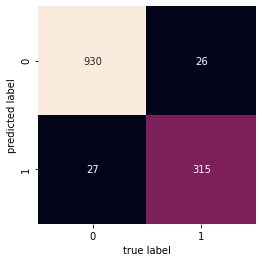

In [58]:
mat = confusion_matrix(valid_labels, predicted_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Porovnanie natrénovaného klasifikátora s manuálne vytvorenými pravidlami z druhej časti

In [59]:
print("Metriky klasifikacie pomocou rozhodovacieho stromu\n\n",classification_report(data_valid['class'], pred_class22, target_names = ["0","1"]))

Metriky klasifikacie pomocou rozhodovacieho stromu

               precision    recall  f1-score   support

           0       0.98      0.87      0.92       957
           1       0.73      0.94      0.82       341

    accuracy                           0.89      1298
   macro avg       0.85      0.91      0.87      1298
weighted avg       0.91      0.89      0.90      1298



In [60]:
print("Metriky klasifikacie pomocou rozhodovacieho stromu\n\n",classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

Metriky klasifikacie pomocou rozhodovacieho stromu

               precision    recall  f1-score   support

           0       0.97      0.97      0.97       957
           1       0.92      0.92      0.92       341

    accuracy                           0.96      1298
   macro avg       0.95      0.95      0.95      1298
weighted avg       0.96      0.96      0.96      1298



## Optimalizácia hyperparametrov

Vyskusali sme hladat v hyperparametroch.
Hyperparametre su vlastne parametre v klasifikatori rozhodovacieho stromu a s ktorymi mozme experimentovat. Zmenou na spravnu kombinaciu parametrov je mozne vylepsit uspesnost daneho klasifikatora

- criterion (string, optional): funkcia na zmeranie kvality rozdelenia. Nadobuda dve hodnoty - "gini" a "entropy"
- splitter (string,optional): strategia pouzita na zvolenie rozdelenia na kazdej node (uzli). Podporovane strategie - "best" a "random".
- max_depth (int | None, optional): maximalna hlbka stromu. Pokial nie je zadana, nody sa splituju az pokial neobsahuju menej uzlov ako min_samples_split
- max_features (int,None): pocet atributov (stlpcov) ktore berie do uvahy pri hladani najlepsieho rozdelenia


Do max_depth a max_features sme dali range hodnot.

In [61]:
from sklearn.model_selection import GridSearchCV
##%%capture --no-display
parameters = {'criterion': ('gini','entropy'), 'splitter': ('best','random'), 'max_depth': range(2,20), 'max_features':range(1,77,5)}
# 10-nasobna cross validacia
optimization = GridSearchCV(clf, parameters,cv=10)
vysledok = optimization.fit(df_train_class, train_labels)
vysledok

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(2, 20),
                         'max_features': range(1, 77, 5),
                         'splitter': ('best', 'random')})

In [62]:
params = optimization.best_params_

In [63]:
clf = tree.DecisionTreeClassifier(
    criterion=params['criterion'],
    max_depth=params['max_depth'],
    max_features=params['max_features'],
    splitter=params['splitter'])

In [64]:
clf = clf.fit(df_train_class, train_labels)

In [65]:
predicted_labels = clf.predict(df_valid_class)
basic_acc = metrics.accuracy_score(valid_labels, predicted_labels)
basic_acc

0.9568567026194145

In [66]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file =None, 
                                feature_names=df_train_class.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("strom2")

'strom2.pdf'

In [67]:
img_strom2 = WImage(filename='strom2.pdf')
img_strom2

NameError: name 'WImage' is not defined

In [ ]:
print(classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

### Záver

V prvom bode sme pomocou funkcií z predchádzajúceho odovzdania upravili obidva datasety. V datasetoch sa nachádzajú niektoré stĺpce obsahujúce kategorické atribúty. Tieto stĺpce sme mali v pláne najkôr dropnuť, pretože sme ich pri trénovaní nepotrebovali, ale nakoniec sme ich tam nechali.

Ďalej sme natrénovali klasifikátor na trénovacích dátach a predikovali sme ich na validačných dátach. Pred optimalizáciou hyperparametrov sme mali pripravený dobre natrénovaný model.

Pri optimalizácií hyperparametrov sme použili metódu optimalizácie gridsearchom a 10-násobnou krížovou validáciou. Toto nám vrátilo najlepšiu kombináciu atributov.

